<a href="https://colab.research.google.com/github/sbkim508/ongoing/blob/ML2021/%5B1%5D_NCF_Check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 데이터 업로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import math
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 전체유저, User Demographic, User profiling : 50,172 명
n_user_info_member = pd.read_csv('./data/n_user_info_member.csv') # , dtype ={'birth_year' : str})

# 검색기록  262,372 건 키워드검색
n_prod_view_log = pd.read_csv('./data/n_prod_view_log.csv', dtype ={'product_id' : str})

# 검색기록 160,552 건
n_search_log = pd.read_csv('./data/n_search_log.csv', dtype ={'product_id' : str})
n_search_log = n_search_log[n_search_log['product_id'] != '          '] # 빈칸 제거

#### 0.1) member_id만 사용

In [ ]:
new_user_info_member = n_user_info_member[n_user_info_member['member_id'].notna()]
print(new_user_info_member.shape)
new_user_info_member.head() # 7,051건

(7051, 20)


,member_id,fcm_token,skin_type,gender,birth_year,skin_tone,personal_color,worry_1,worry_2,worry_3,worry_4,worry_5,worry_6,worry_7,worry_8,worry_9,worry_10,worry_11,worry_12,beauty_level
0,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,APA91bG7s7Vmq2MRcJ6XdeWNkch1ZBHq_HGVW3OOfQ8h4m...,2,F,2010,2,1,1,0,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN
1,WUZwWnFPcFA4TXJ2aHlxdU43aEYxVDltVEtVeVUwWTZzek...,APA91bEIICGY0ERbn7rpinIZHAV9EQHUkZu-0loJk_O4Yc...,4,F,1980,4,1,0,0,1,1,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN
2,X0RUZHM0bHVRdmdTU1N6WFdvdkdQbnFzS3o3OHFLeEQzMk...,APA91bHttKhiQJF3MRc88kBRVJYrvatxifsJ-4Kv9H3kU0...,4,F,2007,4,1,1,0,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,NaN
3,M3NuTWRYWVREeU5zWE5xWVpYOHJkUGpkRUVDa2dpS3A1aE...,coVh6geWV0VXt49xUDKrqe:APA91bF8OqR3URL5mt6Sk7B...,3,F,1999,2,3,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,Qjlncm5RaUNEb0ZzZmxFMW9CTWVlb0xaazRCRVZqMU4tdE...,APA91bGgi9jc-vd5ofry4s0grJIPNrs9FFysMV83hFPYYn...,2,M,2002,4,2,0,0,1,1,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,NaN


#### 0.2) 각 Column 별 유니크 값 확인

In [ ]:
for i in new_user_info_member.columns:
    print("###### {}의 유니크 값 확인 ######".format(i))
    print(new_user_info_member[i].unique())

###### member_id의 유니크 값 확인 ######
['MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVDdvYlAzUzNVOA=='
 'WUZwWnFPcFA4TXJ2aHlxdU43aEYxVDltVEtVeVUwWTZzek10ZVNvLWZQZw=='
 'X0RUZHM0bHVRdmdTU1N6WFdvdkdQbnFzS3o3OHFLeEQzMkJHZDltX3RqWQ==' ...
 'X2lkNm03WmlIdzlwanhqbGZ2Q0xNQWc0R2J2NzJjWE5BZndQd3E0Ymlabw=='
 'Qjc1V3hFQmVxTU55Z1JtemxfeHUtUVdKcmVUNWxMSzRkR3laMW8waW5OVQ=='
 'cjA1c1JNc0YxblAtS2NlaEtRNVh2djBmYUg2b3d5VUwtSG14U1F5UzNHNA==']
###### fcm_token의 유니크 값 확인 ######
['APA91bG7s7Vmq2MRcJ6XdeWNkch1ZBHq_HGVW3OOfQ8h4mf-WgyZbnz70QhHEcw45s6fohl1s_rljSHrm3VTCoPiDulnbW_CzXRG_qfMD9kTF0JkpQznXfwLL9ZGy4UBaa_UXYeKmr8c'
 'APA91bEIICGY0ERbn7rpinIZHAV9EQHUkZu-0loJk_O4YclNrqEMYdcE7_EfhmRa_z1_yBSB-KYINyQDdVqaF4mycuQBryYzU7b6eHKPVHAGDSVP8uvcwyHkSwZo9zkmmwNM-x2zyOvG'
 'APA91bHttKhiQJF3MRc88kBRVJYrvatxifsJ-4Kv9H3kU0Cwkr60O4gDkRm2nPfYYUGMpPzn8YPmnCioxfAzBUHboojFZDNeA1ngqVaLSFxCGOu4r-KaEp69-d7zffs7Kw3uWwBlpuh0'
 ...
 'APA91bGhRXlwl4YoCMBlNXwUkUXl6fAlIxQ4-87ikk8Yi1MOH8SIvxXKb-JwVVkUKgjPJtZFMArp4fk_X5YnlU9IMH4wgsIRv2ZxYBn-

In [ ]:
check_col = ['skin_type','gender','skin_tone','personal_color']
for i in check_col:
    print("###### {}의 유니크 갯수 확인 ######".format(i))
    print(new_user_info_member[i].value_counts())

###### skin_type의 유니크 갯수 확인 ######
             1881
2            1871
3            1262
1            1138
4             899
Name: skin_type, dtype: int64
###### gender의 유니크 갯수 확인 ######
F         5735
M         1316
Name: gender, dtype: int64
###### skin_tone의 유니크 갯수 확인 ######
4            2638
             1881
2            1383
1             875
3             274
Name: skin_tone, dtype: int64
###### personal_color의 유니크 갯수 확인 ######
1                 2175
                  1881
3                 1418
2                  841
4                  736
Name: personal_color, dtype: int64


- .... 그냥 아래에 한번에 처리함 

## 2. User_info 데이터 전처리

In [ ]:
def preprocessing(data):
    df = data.copy()

    # remove the feature
    df.drop(['fcm_token', 'beauty_level'], axis = 1, inplace = True)

    # skin_type
    df['skin_type'].replace('         ', '0', inplace = True)

    # gender
    df['gender'] = [i.strip() for i in df['gender']]          # strip 적용

    gender = {'M' : '0', 'F' : '1'}
    df['gender']  = df['gender'].map(lambda x : gender[x])    # 0과 1로 변경

    # birth_year
    df['birth_year'] = df['birth_year'].astype('int')
    cond1 = (df['birth_year'] > 1950)
    cond2 = (df['birth_year'] < 2016)
    df = df.loc[cond1 & cond2 ,:]
    
    # skin_tone
    df['skin_tone'].replace('         ', '0', inplace = True)

    # personal_color
    df['personal_color'].replace('              ', '0', inplace = True)
    
    # int4로 변경
    int4_col = [s for s in df.columns if "worry" in s] 
    for i in int4_col:
        df = df.astype({i : 'int8'})

    return df

# 적용
user_info_data = preprocessing(new_user_info_member)
print(user_info_data.shape)
user_info_data.head() # 7,004 건

(7004, 18)


,member_id,skin_type,gender,birth_year,skin_tone,personal_color,worry_1,worry_2,worry_3,worry_4,worry_5,worry_6,worry_7,worry_8,worry_9,worry_10,worry_11,worry_12
0,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,2,1,2010,2,1,1,0,0,0,0,0,0,1,1,0,0,1
1,WUZwWnFPcFA4TXJ2aHlxdU43aEYxVDltVEtVeVUwWTZzek...,4,1,1980,4,1,0,0,1,1,0,0,1,1,0,0,0,1
2,X0RUZHM0bHVRdmdTU1N6WFdvdkdQbnFzS3o3OHFLeEQzMk...,4,1,2007,4,1,1,0,0,0,1,0,0,1,0,1,0,1
3,M3NuTWRYWVREeU5zWE5xWVpYOHJkUGpkRUVDa2dpS3A1aE...,3,1,1999,2,3,1,0,1,0,0,0,0,0,0,0,0,0
4,Qjlncm5RaUNEb0ZzZmxFMW9CTWVlb0xaazRCRVZqMU4tdE...,2,0,2002,4,2,0,0,1,1,0,0,0,0,1,1,0,1


## 3. 데이터 탐색

#### 3.1) 고유 User와 검색 기록 수 확인

In [ ]:
print('전체 member_id 유저 수 : ', user_info_data.shape)

prod_view_log = n_prod_view_log[n_prod_view_log['member_id'].isin(user_info_data['member_id'])].drop(['view_log_id','fcm_token'], axis = 1)
search_log = n_search_log[n_search_log['member_id'].isin(user_info_data['member_id'])].drop(['search_log_id','fcm_token'], axis = 1)
print('member_id 유저가 검색한 로그 수 : ',prod_view_log.shape, search_log.shape)

len_prob_log = user_info_data[user_info_data['member_id'].isin(n_prod_view_log['member_id'])]
len_search_log = user_info_data[user_info_data['member_id'].isin(n_search_log['member_id'])]
print('검색한 로그의 member_id 유저 수 : ',len_prob_log.shape, len_search_log.shape)

전체 member_id 유저 수 :  (7004, 18)
member_id 유저가 검색한 로그 수 :  (34711, 2) (8836, 2)
검색한 로그의 member_id 유저 수 :  (3949, 18) (1826, 18)


- 즉, 7,004명 중 3,949명의 유저가 34,711 건을 검색했다고 보면 됨. -> Prod_view
- 즉, 7,004명 중 1,826명의 유저가 8,836 건을 검색했다고 보면 됨.  -> search_view

In [ ]:
prod_view_counts = prod_view_log.groupby('member_id').count().sort_values('product_id', ascending= False)
prod_view_counts.head()

,product_id
member_id,
Z0RMejhsX1o0TkMtZnNjRjMweDgyRl9lMURycWRteTUtYlJaZ3hDWUNrdw==,1850
MklvTlpjQUF1Q2d3bHpVamx1M0RIV1VWME40OUhmZ25OTWU5UjZDWDVpMA==,818
bXhyVGJfTVQtSEhBeTFaWmJOaVU0SnEydWFCVm9TNU0yZDVNbnQ2V2NaNA==,610
UVllbDVITWh3T1dyZVlERjlUU01qSnAtejlXVVFuSWtKR21UeEFtMXNmUQ==,517
TDJMbHRhalV1dnlpclpGem1fX3h3aDdWNXM3VDJCN3FfQmZpbGVyVmFPTQ==,465


In [ ]:
search_view_counts = search_log.groupby('member_id').count().sort_values('product_id', ascending= False)
search_view_counts.head()

,product_id
member_id,
Z0RMejhsX1o0TkMtZnNjRjMweDgyRl9lMURycWRteTUtYlJaZ3hDWUNrdw==,675
TDJMbHRhalV1dnlpclpGem1fX3h3aDdWNXM3VDJCN3FfQmZpbGVyVmFPTQ==,259
eHZkLWhNN0FheVd3UThfV0lnS0ZMd3ROSVhxZDVia0lUZi1lTlVpc3c5UQ==,218
MklvTlpjQUF1Q2d3bHpVamx1M0RIV1VWME40OUhmZ25OTWU5UjZDWDVpMA==,216
Mm51c1gtWGRaQzBxcXpMVmRaZGpObC1vMmpueUF0bEFwT1NLSGFUQk5kWQ==,183


- 검색 기록을 확인하면 로그 건수가 상당히 적다
- 원칙대로라면 3개 미만 검색 기록은 제거해야하나.. 일단 살려두어야 할듯
- fcm token을 활용하여 데이터를 추가해야할지 .. 일단 도전

In [ ]:
merge_search_log1 = prod_view_log.groupby('product_id').count()
merge_search_log1.head()

,member_id
product_id,
1,12
10,2
10001,1
10002,5
10003,6


In [ ]:
merge_search_log2 = search_log.groupby('product_id').count()
merge_search_log2.head()

,member_id
product_id,
1,4
10,1
10002,3
10004,1
1001,2


- product_id당 검색된 기록(Sorting X)

#### 3.2) prob_view와 search_view를 병합

In [ ]:
merge_search_log = pd.merge(merge_search_log1, merge_search_log2, left_index=True, right_index=True, how='outer')
merge_search_log.fillna(0, inplace =True)

merge_search_log['Item_click'] = merge_search_log['member_id_x'] + merge_search_log['member_id_y']
merge_search_log.drop(['member_id_x','member_id_y'], axis =1 , inplace = True)

print(merge_search_log.shape)
merge_search_log.head()

(9450, 1)


,Item_click
product_id,
1,16.0
10,3.0
10001,1.0
10002,8.0
10003,6.0


- 즉, 7,004명의 유저 중 active한 유저(7,004명보다 낮은 3,946명)들이 9,450개의 item을 검색함 

In [ ]:
# import pandas_profiling
# data.profile_report()

# 스킨 타입 유형

# 성별 유형

# 출생연도

# 스킨 톤

# 개인 컬러?

# [유저] 출생연도 분포
# sns.distplot(user_info_data['birth_year'])

- user_info에 대한 EDA 용.. 향후 확인하여 user-info meta data concat

## 4. 데이터 전처리

#### 4.1) User_df 생성(레이블 인코딩 X)

In [ ]:
# user_info_data의 7,004 ID
user_df = pd.DataFrame(user_info_data['member_id'].copy())
print(user_df.shape)
user_df.head()

(7004, 1)


,member_id
0,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...
1,WUZwWnFPcFA4TXJ2aHlxdU43aEYxVDltVEtVeVUwWTZzek...
2,X0RUZHM0bHVRdmdTU1N6WFdvdkdQbnFzS3o3OHFLeEQzMk...
3,M3NuTWRYWVREeU5zWE5xWVpYOHJkUGpkRUVDa2dpS3A1aE...
4,Qjlncm5RaUNEb0ZzZmxFMW9CTWVlb0xaazRCRVZqMU4tdE...


#### 4.2) Click을 구하기 위한 과정

In [ ]:
# prod + search 로그 기록 병합
item_view = pd.concat([prod_view_log,search_log], axis = 0).sort_index() # 34711 + 8836 = 43547

# 개수 카운트
temp_join = pd.DataFrame(item_view.groupby(['member_id', 'product_id']).size()).reset_index()

# 병합
item_view = pd.merge(item_view,temp_join, on = ['member_id', 'product_id'], how = 'left')
item_view.rename(columns = {0 : 'Click'}, inplace = True)

# 중복제거
item_view.drop_duplicates(inplace = True) # 43,547 -> 26,015
print(item_view.shape)
item_view.head()

(26015, 3)


,member_id,product_id,Click
0,NTRqT3J1RHdkLS1oVlJzMHRtV1lvNUt0aWFsN3U1VVg2YU...,4215,2
1,dk5aZmJ0SElaTGVxUzhuRnlkZjhFeElaUTJoNy1ZU1h5VU...,3968,2
2,aGF0cGp5VlozdDdZRnRWbXNjaHpIMWJYQTNUNGNTelNwNm...,3615,1
4,Z3ZVZ2x2YkJVWjlEeGlCSTJVOFN3M1cwWFhmbTVLVmpvN2...,3755,5
5,UE1Vbzh1d3hhNXNhTWRMMTc2LTNaUXltREtMUkQ5R0ZXQz...,6544,2


In [ ]:
print("고유 유저 수 : ", len(user_df['member_id'].unique()))
print("Active user : ", len(item_view['member_id'].unique()))
print("Inactive user : ", len(user_df['member_id'].unique()) - len(item_view['member_id'].unique()))

print("조회된 item 갯수 : ", len(item_view['product_id'].unique()))

고유 유저 수 :  7004
Active user :  3956
Inactive user :  3048
조회된 item 갯수 :  9450


- 7,004 명의 유저 중 3,956명의 유저가 Active, 3,048명의 유저가 inactive 

In [ ]:
na_data_matrix = pd.merge(user_df, item_view, on = 'member_id', how = 'outer')
na_data_matrix

,member_id,product_id,Click
0,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,2816,2.0
1,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,3593,1.0
2,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,5958,1.0
3,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,37334,1.0
4,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,8748,1.0
...,...,...,...
29058,cjA1c1JNc0YxblAtS2NlaEtRNVh2djBmYUg2b3d5VUwtSG...,10416,10.0
29059,cjA1c1JNc0YxblAtS2NlaEtRNVh2djBmYUg2b3d5VUwtSG...,16845,15.0
29060,cjA1c1JNc0YxblAtS2NlaEtRNVh2djBmYUg2b3d5VUwtSG...,6614,1.0
29061,cjA1c1JNc0YxblAtS2NlaEtRNVh2djBmYUg2b3d5VUwtSG...,13181,1.0


- 따라서 3,048명을 지운 3,956명의 유저와 9,450개의 아이템을 가지고 추천시스템 학습

#### 4.3) user_item_matrix 생성

In [ ]:
user_item_clikc = na_data_matrix.dropna().reset_index(drop = True)
user_item_clikc['Click'] = user_item_clikc['Click'].astype('float32') # float64 -> 32로 변환하여 메모리절감
user_item_clikc['product_id'] = user_item_clikc['product_id'].astype('int64')
user_item_clikc # 3,956의 유저

,member_id,product_id,Click
0,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,2816,2.0
1,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,3593,1.0
2,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,5958,1.0
3,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,37334,1.0
4,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,8748,1.0
...,...,...,...
26010,cjA1c1JNc0YxblAtS2NlaEtRNVh2djBmYUg2b3d5VUwtSG...,10416,10.0
26011,cjA1c1JNc0YxblAtS2NlaEtRNVh2djBmYUg2b3d5VUwtSG...,16845,15.0
26012,cjA1c1JNc0YxblAtS2NlaEtRNVh2djBmYUg2b3d5VUwtSG...,6614,1.0
26013,cjA1c1JNc0YxblAtS2NlaEtRNVh2djBmYUg2b3d5VUwtSG...,13181,1.0


In [ ]:
temp = user_item_clikc.groupby('product_id').count()
temp[temp['Click'] >= 3]

,member_id,Click
product_id,,
1,10,10
2,17,17
3,4,4
7,5,5
8,5,5
...,...,...
41263,3,3
41522,7,7
41525,4,4


- evaluate metric이 무엇이 될지 고민
- 추천은 해주긴 할텐데 loss 학습이 잘 될까?

In [ ]:
# import pandas_profiling
# user_item_clikc.profile_report()

In [ ]:
# user_item_clikc.to_csv('./data/raw_clicks.csv', index = False)

#### 4.4) 매트릭스 형태 

In [ ]:
# pivot Clicks into id features
user_item_matrix = user_item_clikc.pivot(
    index='member_id',
    columns='product_id',
    values='Click'
).fillna(0)

# 3,956명의 유저와 2,136개의 아이템
user_item_matrix 

product_id,1,2,3,5,7,8,9,10,11,12,...,41701,41702,41705,41707,41708,41735,41740,41741,41754,41762
member_id,,,,,,,,,,,,,,,,,,,,,
LS1FMWJ3cG5qaVRWdzBQQWlnZkl3SGowdUpMWXFKTmwyZlhlMnNJVzZtZw==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LTBDR2FkbUFPLTFuY2lmYkNXQVJ5U1liU1liVllETTlfTFp2bW44N2Vadw==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LTFlVGU5VXE5Qnl5WkM4amgyYmp4N3FVaFpwYTcyVFJZc3FBVENENlJ6SQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LTFnQmVwbllnZURacjdYcjZDWGx0TFBBdnc2QWVmWmtWX2pOUFNCNmZrUQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LTFvTnVVdUlMVHY5bTd0WXNQd2Y3LU1ra3dFSVBrb0ZjZTZrdWg0YUJDSQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
enJTckl2aHA3YVV2OXF4X0tOR0RuSjg3WERyeWJJNURCd1BPME5BQVdmbw==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
enVvR2pNNG1oZFRlN2tzcmtmNHdNY2ZmbE9lQTBKbXE3dm8zeE5LS0F0bw==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
enc0cUZ3eWdZYTY4dGpGYUxibkE0R3pHaGFuQzdWaG1CMm5GRUM3N0I3SQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_item_matrix.info() # 285 -> 142mb

<class 'pandas.core.frame.DataFrame'>
Index: 3956 entries, LS1FMWJ3cG5qaVRWdzBQQWlnZkl3SGowdUpMWXFKTmwyZlhlMnNJVzZtZw== to enpldmRYTVJZOEZGd2ZpWk9McHk2X3FTRGZoNGd6QVdnZ3JBQk9RMkpBdw==
Columns: 9450 entries, 1 to 41762
dtypes: float32(9450)
memory usage: 142.6+ MB


- 만약.. 한다면.. 개연성(matrix로 구성) + 임의성(없는 product_id를 랜덤하여 click 1로 고정)


- SVD or AutoEncoder



- user

#### user_info_meta 데이터

In [ ]:
user_info_df = user_info_data[user_info_data['member_id'].isin(user_item_clikc['member_id'])].reset_index(drop = True)
user_info_df

,member_id,skin_type,gender,birth_year,skin_tone,personal_color,worry_1,worry_2,worry_3,worry_4,worry_5,worry_6,worry_7,worry_8,worry_9,worry_10,worry_11,worry_12
0,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,2,1,2010,2,1,1,0,0,0,0,0,0,1,1,0,0,1
1,WUZwWnFPcFA4TXJ2aHlxdU43aEYxVDltVEtVeVUwWTZzek...,4,1,1980,4,1,0,0,1,1,0,0,1,1,0,0,0,1
2,X0RUZHM0bHVRdmdTU1N6WFdvdkdQbnFzS3o3OHFLeEQzMk...,4,1,2007,4,1,1,0,0,0,1,0,0,1,0,1,0,1
3,RkNKdkxGeHZnXzRvQ25TUDQ4a25zZE90aTZ6Ml9hZ2FHLT...,2,1,1984,1,2,1,1,0,1,1,0,0,0,0,0,0,1
4,LU1JTm5rSGZoOTBKM0Q4Zy1DSVRveGI4NFJfY3JoejRaWV...,3,1,1995,1,4,0,1,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,R01mY0J5UFdRSG1JcC1rcVRsSmdyczhKT3hqZXNWM1kycF...,0,1,1979,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3952,ZDVqakg2SlNocDFrZzBscHJTSDMtdlVLNFEtbHlCU2UyNG...,2,1,1994,2,1,1,1,1,0,0,0,1,1,0,0,0,0
3953,amhZQkNhaWZDNWNCR2kzTVdNUkVjWFlzNGtHUjBtOGNMZE...,4,1,1982,4,3,1,0,0,0,0,0,1,1,1,0,0,1
3954,Qjc1V3hFQmVxTU55Z1JtemxfeHUtUVdKcmVUNWxMSzRkR3...,2,1,1980,1,4,0,0,1,1,0,0,0,0,1,0,1,1


In [ ]:
cond1 = (user_info_df['birth_year'] >= 2002)
cond2 = (user_info_df['gender']==1)

user_info_df.loc[cond1 & cond2, :]

,member_id,skin_type,gender,birth_year,skin_tone,personal_color,worry_1,worry_2,worry_3,worry_4,worry_5,worry_6,worry_7,worry_8,worry_9,worry_10,worry_11,worry_12


In [ ]:
user_info_df[(user_info_df['gender']=='1') & (user_info_df['birth_year'] > 2002)]

,member_id,skin_type,gender,birth_year,skin_tone,personal_color,worry_1,worry_2,worry_3,worry_4,worry_5,worry_6,worry_7,worry_8,worry_9,worry_10,worry_11,worry_12
0,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,2,1,2010,2,1,1,0,0,0,0,0,0,1,1,0,0,1
2,X0RUZHM0bHVRdmdTU1N6WFdvdkdQbnFzS3o3OHFLeEQzMk...,4,1,2007,4,1,1,0,0,0,1,0,0,1,0,1,0,1
6,azdjdzFTTkRtZnVWbVFkZmFMVG5icnpqMzk0QW9YVVJQXz...,3,1,2006,4,3,1,0,1,0,0,1,0,1,0,0,1,0
12,WkM2OS1NNTJoenNVSURxQVYtYWVtYnVaaS0zTEdxTFpuOU...,0,1,2007,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,emtHYzNib25BS2hSRXpidzVOWFpwYXFJMkg0aUhJRThkUD...,4,1,2010,2,3,0,1,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938,UVN5dGtQc01ac3FUOWozek9wM0FubTFraWY4d0RjMTVOdU...,1,1,2006,1,1,0,0,0,0,1,0,0,1,1,1,1,0
3947,bzdlNVBLSkpyZ2V6dk1ISXlxZG4ycW5ycWVkNl94V2ZGX0...,4,1,2005,4,1,1,0,0,0,1,0,0,0,1,0,0,0
3948,SDZqYjlFU04yUkN1RzdZX0xVU1lCWmVLcVBqUDdvUERic3...,4,1,2005,4,2,1,0,0,0,0,0,0,1,1,0,0,0
3949,N05CNWFBb1l0c3BfNDdjUlFOVlZnRVJEYzYwVWRPcWRpdD...,1,1,2007,1,2,1,0,0,0,0,0,1,1,1,0,0,1


## 5. 모델링

- 유저정보 : user_info_df
- 유저아이템매트릭스 : user_item_matrix

In [ ]:
# user_info_df

# SVD, AutoEncoder

# Neural Collaborative filtering

# Top 5 ~ 10 

## 8/17 ~ 수정 진행

In [ ]:
temp = user_item_clikc.copy()
temp['Click'] = 1.0
temp['Click'] = temp['Click'].astype('float16')

# user_item_clikc['Click'] = user_item_clikc['Click'].astype('float32')

In [ ]:
def fill_product_id(data):
    df = data.copy()
    df['Click'] = df['Click'].astype('float16')
    result_data = data.copy() # 원본데이터
    unique_product_id_list = df['product_id'].unique()
    
    
    for i in tqdm(range(len(df['member_id'].unique()))):
        # 멤버 아이디 3900개 별로
        unique_member_id = (df['member_id'].unique()[i])

        # 그 멤버 아이디에 해다하는 product_id 저장
        unique_product_id = df[df['member_id'] == unique_member_id]['product_id'].unique().tolist()

        # 차집합
        fill_product_id = list(set(unique_product_id_list) - set(unique_product_id))     
        
        # 데이터 프레임 형성
        user_id_list = [unique_member_id] * len(fill_product_id)

        result_df = pd.DataFrame({
            'member_id': user_id_list,
            'product_id': fill_product_id,
            'Click' : 0.0})

        # 데이터 병합
        result_data = result_data.append(result_df, ignore_index = True)
    
    result_data['Click'] = result_data['Click'].astype('float16')

    return result_data

In [ ]:
final_data = user_item_clikc.copy()
final_data['Click'] = 1.0
final_data['Click'] = final_data['Click'].astype('float16')


In [ ]:
model_data = fill_product_id(final_data)

100%|██████████| 3956/3956 [33:13<00:00,  1.98it/s]


In [ ]:
model_data.shape

(37384200, 3)

In [ ]:
model_data.to_csv('./data/model_data.csv', index = False)

In [ ]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37384200 entries, 0 to 37384199
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   member_id   object 
 1   product_id  int64  
 2   Click       float16
dtypes: float16(1), int64(1), object(1)
memory usage: 641.7+ MB


In [ ]:
model_data.head()

,member_id,product_id,Click
0,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,2816,1.0
1,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,3593,1.0
2,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,5958,1.0
3,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,37334,1.0
4,MlRwTkpBOHdmd1pHeVFGZDBnSkRvSm5fQ1FaekNGQ2NRVD...,8748,1.0


In [ ]:
model_data['Click'].value_counts()

0.0    37358185
1.0       26015
Name: Click, dtype: int64

## 8/17 ~ 수정 진행

# 8/14 모델링 테스트

In [ ]:
user_item_clikc['Click'] = [i if i <= 3 else 3 for i in user_item_clikc['Click']] # 3 이상은 무조건 3
user_item_clikc['Click'].value_counts()

1.0    14871
2.0     8683
3.0     2461
Name: Click, dtype: int64

In [ ]:
user_item_clikc.to_csv('./data/clicks.csv', index = False)

In [ ]:
data_path = "/content/drive/MyDrive/data/"

def read_data(data_path):
    df = pd.read_csv(os.path.join(data_path,'model_data.csv')) # clicks.csv 
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)
    return train_df, val_df



In [ ]:
train_df, val_df = read_data(data_path)

print(train_df.shape, val_df.shape)
train_df.head()

<AxesSubplot:>

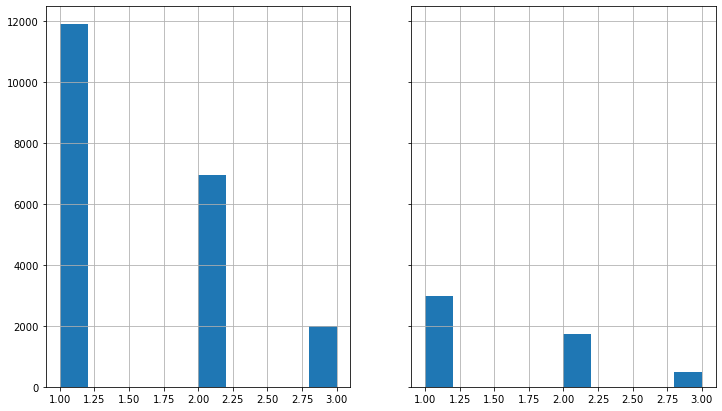

In [ ]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel()

train_df['Click'].hist(ax=ax[0])
val_df['Click'].hist(ax=ax[1])

In [ ]:
train_df['Click'].describe()

count    20812.000000
mean         1.524169
std          0.663108
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: Click, dtype: float64

# Dataset Loader(member_id,  product_id, Click)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from tqdm import tqdm
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import math
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path = "/content/drive/MyDrive/data/"

def read_data(data_path):
    df = pd.read_csv(os.path.join(data_path,'model_data.csv')) # clicks.csv 
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)
    return train_df, val_df



In [3]:
torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

device(type='cuda', index=0)

In [4]:
class DatasetLoader:
    def __init__(self, data_path):
        self.train_df, val_temp_df = read_data(data_path)

        # 최소 최대 범위 정의
        self.min_rating = min(self.train_df.Click)
        self.max_rating = self.train_df.Click.max()

        self.unique_users = self.train_df.member_id.unique()
        self.num_users = len(self.unique_users)
        self.user_to_index = {original: idx for idx, original in enumerate(self.unique_users)}
        # 0 1 0 0 0 ... 0

        self.unique_products = self.train_df.product_id.unique()
        self.num_products = len(self.unique_products)
        self.product_to_index = {original: idx for idx, original in enumerate(self.unique_products)}

        self.val_df = val_temp_df[val_temp_df.member_id.isin(self.unique_users) & val_temp_df.product_id.isin(self.unique_products)]

    def generate_trainset(self):
        # user 0, 0, 0, 1,2, 3,3, -> product : 0,0,0,0,0,0,
        X_train = pd.DataFrame({'member_id': self.train_df.member_id.map(self.user_to_index),
                     'product_id': self.train_df.product_id.map(self.product_to_index)})
        y_train = self.train_df['Click'].astype(np.float16)

        return X_train, y_train

    def generate_valset(self):
        X_val = pd.DataFrame({'member_id': self.val_df.member_id.map(self.user_to_index),
                              'product_id': self.val_df.product_id.map(self.product_to_index)})
        y_val = self.val_df['Click'].astype(np.float16)
        return X_val, y_val

In [5]:
class FeedForwardEmbedNN(nn.Module):

    def __init__(self, n_users, n_products, hidden, dropouts, n_factors, embedding_dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.product_emb = nn.Embedding(n_products, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden_layers = nn.Sequential(*list(self.generate_layers(n_factors*2, hidden, dropouts)))
        self.fc = nn.Linear(hidden[-1], 1)

    def generate_layers(self, n_factors, hidden, dropouts):
        assert len(dropouts) == len(hidden)

        idx = 0
        while idx < len(hidden):
            if idx == 0:
                yield nn.Linear(n_factors, hidden[idx])
            else:
                yield nn.Linear(hidden[idx-1], hidden[idx])
            yield nn.ReLU()
            yield nn.Dropout(dropouts[idx])

            idx += 1

    def forward(self, users, products, min_rating=0.5, max_rating=5):
        concat_features = torch.cat([self.user_emb(users), self.product_emb(products)], dim=1)
        x = F.relu(self.hidden_layers(concat_features))
        # 0과 1사이의 숫자로 나타낸다
        out = torch.sigmoid(self.fc(x))
        # rating으로 변환한다
        out = (out * (max_rating - min_rating)) + min_rating

        return out

    def predict(self, users, products):
        # return the score
        output_scores = self.forward(users, products)
        return output_scores

In [6]:
class BatchIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)

        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k * bs:(k + 1) * bs], self.y[k * bs:(k + 1) * bs]


In [7]:
def batches(X, y, bs=32, shuffle=True):
    for x_batch, y_batch in BatchIterator(X, y, bs, shuffle):
        x_batch = torch.LongTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        yield x_batch, y_batch.view(-1, 1)

# Train

In [8]:
def model_train(ds, config):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # GPU 설정

    X_train, y_train = ds.generate_trainset()
    X_valid, y_valid = ds.generate_valset()
    print(f'TrainSet Info: {ds.num_users} users, {ds.num_products} products')

    model = FeedForwardEmbedNN(
        n_users=ds.num_users, n_products=ds.num_products,
        n_factors=config['num_factors'], hidden=config['hidden_layers'],
        embedding_dropout=config['embedding_dropout'], dropouts=config['dropouts']
    )
    
    ##########################################
    
    model.to(device) # GPU 설정

    batch_size = config['batch_size']
    num_epochs = config['num_epochs']
    max_patience = config['total_patience']
    num_patience = 0
    best_loss = np.inf

    criterion = nn.MSELoss(reduction='sum')
    criterion.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    result = dict()
    for epoch in tqdm(range(num_epochs)):
        training_loss = 0.0
        for batch in batches(X_train, y_train, shuffle=True, bs=batch_size):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # with torch.no_grad() 와 동일한 syntax 입니다
            with torch.set_grad_enabled(True):
                outputs = model(x_batch[:, 0], x_batch[:, 1], ds.min_rating, ds.max_rating)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            training_loss += loss.item()
        result['train'] = training_loss / len(X_train)

        # Apply Early Stopping criteria and save best model params
        val_outputs = model(torch.LongTensor(X_valid.member_id.values).to(device),
                            torch.LongTensor(X_valid.product_id.values).to(device), ds.min_rating, ds.max_rating)
        val_loss = criterion(val_outputs.to(device), torch.FloatTensor(y_valid.values).view(-1, 1).to(device))
        result['val'] = float((val_loss / len(X_valid)).data)

        if val_loss < best_loss:
            print('Save new model on epoch: %d' % (epoch + 1))
            best_loss = val_loss
            result['best_loss'] = val_loss
            torch.save(model.state_dict(), config['save_path'])
            num_patience = 0
        else:
            num_patience += 1

        print(f'[epoch: {epoch+1}] train: {result["train"]} - val: {result["val"]}')

        if num_patience >= max_patience:
            print(f"Early Stopped after epoch {epoch+1}")
            break

    return result

In [9]:
def model_valid(user_id_list, product_id_list, data_path):
    dataset = DatasetLoader(data_path)
    processed_test_input_df = pd.DataFrame({
        'member_id': [dataset.user_to_index[x] for x in user_id_list],
        'product_id': [dataset.product_to_index[x] for x in product_id_list]
    })

    # 학습한 모델 load하기 
    my_model = FeedForwardEmbedNN(dataset.num_users, dataset.num_products,
                       config['hidden_layers'], config['dropouts'], config['num_factors'], config['embedding_dropout'])
    my_model.load_state_dict(torch.load('params.data'))
    prediction_outputs = my_model.predict(users=torch.LongTensor(processed_test_input_df.member_id.values),
                     products=torch.LongTensor(processed_test_input_df.product_id.values))

    return prediction_outputs

In [10]:
dataset = DatasetLoader(data_path)

In [11]:
config = {
  "num_factors": 16,
  "hidden_layers": [64, 32, 16],
  "embedding_dropout": 0.05,
  "dropouts": [0.3, 0.3, 0.3],
  "learning_rate": 1e-3,
  "weight_decay": 1e-5,
  "batch_size": 512,
  "num_epochs": 1,                # 에폭 및 배치 조정
  "total_patience": 30,
  "save_path": "params.data"
}

In [12]:
model_train(dataset, config)

TrainSet Info: 3956 users, 9450 products


100%|██████████| 1/1 [03:32<00:00, 212.96s/it]

Save new model on epoch: 1
[epoch: 1] train: 0.0008494620425009348 - val: 0.000669816683512181


{'best_loss': tensor(5008.1123, device='cuda:0', grad_fn=<MseLossBackward>),
 'train': 0.0008494620425009348,
 'val': 0.000669816683512181}

In [13]:
train_df, val_df = read_data(data_path)

print(train_df.shape, val_df.shape)
train_df.head()

(29907360, 3) (7476840, 3)


,member_id,product_id,Click
1233313,b2JRQjJicUxLdzdRLXFwUTU0ZUtlYTFMNW9sZkNWNzlFNk...,21411,0.0
9975209,b3QwMnF4cnNHdmNIaXlsVTAzcDhEVnJuU25Ta19UWERVbX...,5468,0.0
27879964,Ty1vZi1WRkJyY0MwLWNoYjJLbUU0VWRIU2FrUDg0UTIyWk...,1791,0.0
24540249,UERrWUEteFNlR2xKMHJ0amEtVDlmTmt1N1FxdlhpQy02QV...,40480,0.0
5870084,Vm84NVo1OWtkQnlSRW9rTkUtMDVvZUY0dVkxcERSS20xOD...,17531,0.0


In [38]:
product_id_list = val_df['product_id'].unique().tolist() # 전체 아이템 9,450 개
member_id = val_df['member_id'].unique().tolist()[3272]     # 특정 유저   1명
user_id_list = [member_id] * len(product_id_list)
pred_results = [float(x) for x in model_valid(user_id_list, product_id_list, data_path)]

result_df = pd.DataFrame({
    'member_Id': user_id_list,
    'product_Id': product_id_list,
    # 'movieName': [movieName_dict[x] for x in product_id_list],  # <- user or product info meta data # 메타정보 추가하여 확인
    # 'genres': [genres_dict[x] for x in product_id_list],
    'pred_clicks': pred_results
})

result_df.sort_values(by='pred_clicks', ascending=False)[:10]

,member_Id,product_Id,pred_clicks
4548,ajBKLVRDTFB0TV8wbjBjSXZfMVFyTGRrRExRTWsxTkM2Tz...,8641,0.882277
663,ajBKLVRDTFB0TV8wbjBjSXZfMVFyTGRrRExRTWsxTkM2Tz...,37252,0.750425
1225,ajBKLVRDTFB0TV8wbjBjSXZfMVFyTGRrRExRTWsxTkM2Tz...,6614,0.719345
9039,ajBKLVRDTFB0TV8wbjBjSXZfMVFyTGRrRExRTWsxTkM2Tz...,2816,0.709849
3762,ajBKLVRDTFB0TV8wbjBjSXZfMVFyTGRrRExRTWsxTkM2Tz...,3972,0.659499
3352,ajBKLVRDTFB0TV8wbjBjSXZfMVFyTGRrRExRTWsxTkM2Tz...,6129,0.655615
5514,ajBKLVRDTFB0TV8wbjBjSXZfMVFyTGRrRExRTWsxTkM2Tz...,2627,0.632182
9252,ajBKLVRDTFB0TV8wbjBjSXZfMVFyTGRrRExRTWsxTkM2Tz...,37465,0.629920
6206,ajBKLVRDTFB0TV8wbjBjSXZfMVFyTGRrRExRTWsxTkM2Tz...,41369,0.595561
1178,ajBKLVRDTFB0TV8wbjBjSXZfMVFyTGRrRExRTWsxTkM2Tz...,2028,0.584656


In [34]:
result_df.sort_values(by='pred_clicks', ascending=False)[:10] # 0번

,member_Id,product_Id,pred_clicks
3352,bWpXd0pUZElNTU5qT0ljbEhmRU1BU0NQbXRVc0pxamNxNG...,6129,0.828062
4548,bWpXd0pUZElNTU5qT0ljbEhmRU1BU0NQbXRVc0pxamNxNG...,8641,0.820814
1225,bWpXd0pUZElNTU5qT0ljbEhmRU1BU0NQbXRVc0pxamNxNG...,6614,0.812422
663,bWpXd0pUZElNTU5qT0ljbEhmRU1BU0NQbXRVc0pxamNxNG...,37252,0.808108
3933,bWpXd0pUZElNTU5qT0ljbEhmRU1BU0NQbXRVc0pxamNxNG...,8953,0.713744
5514,bWpXd0pUZElNTU5qT0ljbEhmRU1BU0NQbXRVc0pxamNxNG...,2627,0.686981
4359,bWpXd0pUZElNTU5qT0ljbEhmRU1BU0NQbXRVc0pxamNxNG...,3183,0.657381
9252,bWpXd0pUZElNTU5qT0ljbEhmRU1BU0NQbXRVc0pxamNxNG...,37465,0.645999
3762,bWpXd0pUZElNTU5qT0ljbEhmRU1BU0NQbXRVc0pxamNxNG...,3972,0.643934
5067,bWpXd0pUZElNTU5qT0ljbEhmRU1BU0NQbXRVc0pxamNxNG...,20471,0.635536


In [36]:
result_df.sort_values(by='pred_clicks', ascending=False)[:10] # 2번

,member_Id,product_Id,pred_clicks
1225,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,6614,0.819633
3352,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,6129,0.799958
4548,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,8641,0.754699
663,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,37252,0.742318
1053,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,3681,0.739312
3762,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,3972,0.670714
5514,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,2627,0.662649
684,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,32065,0.637643
797,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,3246,0.596987
9039,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,2816,0.587364


In [29]:
product_id_list = val_df['product_id'].values.tolist()[:5]

# product_id_list = [8817, 3451, 8641, 131, 24264, 6633]
member_id = val_df['member_id'].values[2]
user_id_list = [member_id] * len(product_id_list)
pred_results = [float(x) for x in model_valid(user_id_list, product_id_list, data_path)]

result_df = pd.DataFrame({
    'member_Id': user_id_list,
    'product_Id': product_id_list,
    # 'movieName': [movieName_dict[x] for x in product_id_list],  # <- user or product info meta data # 메타정보 추가하여 확인
    # 'genres': [genres_dict[x] for x in product_id_list],
    'pred_clicks': pred_results
})

result_df.sort_values(by='pred_clicks', ascending=False)

,member_Id,product_Id,pred_clicks
4,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,39753,0.500804
3,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,31991,0.500649
2,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,20870,0.500210
0,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,4750,0.500209
1,V3Aza3BTNldQT3loUnFQZXVuLTBYMjBzc0ZaYzVKdWdyRT...,12782,0.500019


- 제대로 안했기에 똑같은 값 출력, 이를 수정해야 함
- 일단 돌아가더라
- 당연히 skew된 데이터이기에 이럴수도.. 사후검정 필요
- user-item과 interaction을 통해 0,1로 변경 -> 그렇지않아서 0.5 고정된 출력값을 내는 걸수도..
- 0,1,2,3 으로 클릭수를 낮추는 방법도 하나의 방법이 되겠다. 0~ 89 까지면 너무 크니까
-> 해보니까 좀 다르게 나오더라
- clikc을 CTR로 변경, Top K를 산출
- user_info meta data 결합 필요

- 기존 user-item Latent vector을 가지고 click 확률을 구했음, 이를 통해 vector간 클릭 예측률을 확인
- 단, unseen한 product_id에 대해 추천해주지 못하는 cold-start문제가 있는데, 임의성(Randomness)를 추가하여 추천하는 방법도..
- 이를 토대로 사후검정하고, 강화하는 방향으로..

- Wide & Deep을 사용 시 Feature Engineering이 필요한데, 기존 raw_data에서 추가할 feature들을 탐색 (such as HASH)

### 8/17 정리

- 1. Top K 만들어야하고
- 2. 1,2,3 -> 0,1로 변경
- 3. unseen한 product_id (0인 값)을 고려하기 (왜냐하면 val에서 없는 것이 오류 뜸)
- 4. XX 새로운 product_id 들어왔을 때, 고민해보기.. XX
- 5. context feature  + latent vector [concat]
- 6. 프로덕트ID가 없는거에 val에서 지금 안뜸, 그래서 0값도 넣어야하나? 
- 7. 문제는 train_df에 있는 id랑 val_df id랑 없는게 있음. 그래서 이를 해결해야함.